# CSC424 - Machine Learning - Assignment 5

<br>

### Team - Random Access Memories
> #### Rivu Bhattacharjee — 1910626
> #### Ahnaf Abdullah — 2130223
> #### Tausia Tahsin Nuzum — 2221415



## Assignment 5A

#### Problem Statement
1. 	In this assignment, we will develop a LSTM  based language model that will suggest the rest of the sentence for given partial input sentence.

2. 	The idea is to simulate Google's suggestions when we try to search.

3. 	For example: if you input “I eat”, output suggestion will be “rice in a restaurant”. The suggestion would be based on the training with hundreds of English sentences found here.  

4. 	Please note that though this dataset is supplied for emotion recognition as downstream task, we can use the sentences for our next word prediction by removing label of the sentence. So remove the last column (the emotion label)from your train, validation, and test set. Now you can use the train set to train  your model for next word prediction.

5. 	Your maximum sentence length is 20  words. So in this model, you will use 20  LSTM   to capture the recurrence.  Word2vec    word embedding would be used for input to the LSTM cells.
6. 	During the training, if the sentence is less than 20 words, you will use EOL to fill up the sentence. EOL will have a unique one hot encoding. If any sentence is more than 20 words long, you will trim the sentence.
7.	So training with this language model will help the model learn the word sequences in next word prediction setting.

    a.	At first, read all sentences from the given dataset, clip them in to 20  word sentences. Add EOL if necessary. Get the word2vec embeddings for all the unique words. Split the Train, validation, and test dataset

    b.	Build the language model with LSTM cell for 20  recurrences. Use the lstm cell from pytorch library to build your lstm based language model

    c.	Use the sentences for training by following the next word prediction setting.

    d.	Example of training sentences would be supplied to the language model as follows:

        i.	Input: I drink tea eol eol eol eol eol … eol, Output: drink tea eol eol eol eol…..eol
        ii.	Input: Bangladesh has been playing cricket since 2000 eol, eol ….. eol, Output:  has been playing cricket since 2000 eol, eol ….. eol,
        iii.	Input: I drink coffee in café eol eol eol ….. eol. Output:  drink coffee in café eol eol eol ….. eol

8.	During the training, cross entropy loss will be applied.

9.	After training, take test data (make partial sentences) and predict the rest of the sentences. Calculate the prediction accuracy with the ground truth.


#### Setup

In [19]:
### IMPORTS
import torch
import torchvision.transforms as transforms
import kagglehub       # Load the dataset
import pathlib         #
from tqdm.notebook import tqdm
from gensim.models import Word2Vec
from torch.utils.data import DataLoader, Dataset
import os

### CONSTANTS
WORD_VEC_SIZE = 300         # size of the vectors to be used as word embeddings
MAX_LEN = 20                  # number of words to generate
batch_size = 64           # Hyperparameter, constant for now


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Define device (CPU or GPU)
# try:
#     device = torch_directml.device()
# except:
#     pass
# print("Device used:", device)

In [20]:
### HELPER METHODS
class Helpers:

    @staticmethod
    def getvocab(sentences: list):
        vocab = set(word for s in sentences for word in s)

        return vocab

    @staticmethod
    def __process_rawtextfile_into_sentences(path: str):
            f = open(path, "r")
            rawtext = f.read().split('\n')
            ret = []

            for sentence in rawtext:
                if sentence != '':
                    sentence = sentence.split(';')[0]
                    ret.append(sentence)

            f.close()
            return ret

    @staticmethod
    def __preprocess_sentences(raw_sentences):
            processed = []
            count = 0
            trim_affected = 0
            for sentence in raw_sentences:
                count += 1
                words = sentence.strip().split()
                if len(words) > 20:   # Trim if longer than 20 words
                    words = words[:20]
                    trim_affected += 1

                #while len(words) < 20:    # Add EOL tokens if shorter than 20 words
                    #words.append('EOL')
                processed.append(words)
            return processed#, trim_affected/count

    @staticmethod
    def produce_rawdataset(path:str):
        sentences = Helpers.__process_rawtextfile_into_sentences(path)
        sentences = Helpers.__preprocess_sentences(sentences)    # 38.5% of test sentences are affected by trimming, this will negatively affect the quality of the output

        return sentences


In [21]:
# Transformations: Convert to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load the dataset
pth = pathlib.Path(kagglehub.dataset_download("praveengovi/emotions-dataset-for-nlp"))
print("Raw text files at:", pth)

# Process text files into list of tokenized sentences
train_sentences = Helpers.produce_rawdataset(pth.joinpath('train.txt'))
val_sentences = Helpers.produce_rawdataset(pth.joinpath('val.txt'))
test_sentences = Helpers.produce_rawdataset(pth.joinpath('test.txt'))

# Display dataset example
print(train_sentences[0])



Raw text files at: /root/.cache/kagglehub/datasets/praveengovi/emotions-dataset-for-nlp/versions/1
['i', 'didnt', 'feel', 'humiliated']


In [22]:
### DATALOADER
class SentencePredictionDataset(Dataset):
    def __init__(self, file, word_to_idx, max_len=20, sentences_list: list=None):
        self.data = []

        if file is not None:
            sentences = Helpers.produce_rawdataset(file)
        else:
            if sentences_list is None:
                raise Exception("Both file and list should not be none!")
            sentences = sentences_list


        for sentence in sentences:
            # Convert words to indices
            indices = [word_to_idx.get(word, word_to_idx['UNK']) for word in sentence]

            # Pad with EOL tokens
            while len(indices) < max_len:
                indices.append(word_to_idx['EOL'])

            # Create input (full sequence) and target (shifted sequence)
            input_seq = indices[:-1]  # All words except last
            target_seq = indices[1:]  # All words except first

            # maybe append more sequences than something that only predicts one word? maybe predict like 2/3/4/5 words?

            self.data.append((input_seq, target_seq))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_seq, target_seq = self.data[idx]
        return torch.tensor(input_seq), torch.tensor(target_seq)

#### Construct Word Embeddings and Word IDs

In [23]:
# Produce word embeddings that contain positional and contextual/semantic information about the language by training a model using our dataset and have it produce vectors that represent each word in our dataset

print("Producing word2vec model")
# to produce an embedding, we must teach it the semantics of the language by giving it our dataset first
print(train_sentences[0])
embedding_model = Word2Vec(train_sentences+val_sentences,
                    vector_size=WORD_VEC_SIZE,
                    window=5,  # Context window size
                    min_count=2,  # Include all words, even rare ones
                    workers=os.cpu_count())  # Number of CPU threads to use
print("Defined")

Producing word2vec model
['i', 'didnt', 'feel', 'humiliated']
Defined


In [24]:
def generate_word_to_idx(v, id_file_location: pathlib.Path):

    def make_dictionary(v: set):
        v = v.union(['EOL', 'UNK'])    # special command tokens
        d = {word: idx for idx, word in enumerate(v)}
        return d

    # avoid changing word-id mappings every time we run the program
    if (id_file_location.is_file()):
        f = open(id_file_location, 'rb')
        word_to_idx = torch.load(f)

        different = False
        for word in v:
            if word not in word_to_idx.keys():
                different = True

        if (different):   # check if dataset changed to have new words, etc
            print("""Vocab seems to have changed, probably because the dataset changed... renewing
                IDs and disregarding id file, {}-idfile vs {}-dataset""".format(len(word_to_idx), len(v)))
            word_to_idx = make_dictionary(v)
    else: # doesn't exist, create
                # needed cause vocab is a set(fast), and the elements in it are unordered
        word_to_idx = make_dictionary(v)

    # write mappings to file
    import os
    os.makedirs(os.path.dirname(id_file_location), exist_ok=True)
    torch.save(word_to_idx, open(id_file_location, 'wb'))
    return word_to_idx

vocab = Helpers.getvocab(train_sentences + val_sentences)
word_to_idx = generate_word_to_idx(vocab, pathlib.Path('data/SentencePredictionDataset/vocab_id.dat'))
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

<ipython-input-24-4437f4dcff8d>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  word_to_idx = torch.load(f)


In [25]:
def create_embedding_dict(word2vec_model, vocabulary):
    """
    Creates a dictionary mapping each word to its vector representation
    Also handles the special EOL token
    """
    embedding_dim = word2vec_model.vector_size
    word_to_vec = {}
    not_in_wv = 0

    for word in vocabulary:
        if word in word2vec_model.wv:
            word_to_vec[word] = word2vec_model.wv[word]
        else:
            # For unknown words set a random vector (word2vec uses numpy arrays)
            #print("Does this really happen?")
            not_in_wv += 1
            word_to_vec[word] = torch.rand(embedding_dim).numpy()

    # Add EOL token if not already in vocabulary
    if 'EOL' not in word_to_vec:
        word_to_vec['EOL'] = torch.rand(embedding_dim).numpy()

    if 'UNK' not in word_to_vec:
        word_to_vec['UNK'] = torch.rand(embedding_dim).numpy()

    print("{} words not learned by the word2vec model, were assigned random vectors".format(not_in_wv))
    return word_to_vec

embedding = create_embedding_dict(embedding_model, vocab)

7104 words not learned by the word2vec model, were assigned random vectors


#### Model Definition

In [40]:
import torch.nn as nn
class LSTM_20(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, word_to_vec):
        super().__init__()

        self.hidden_dim = hidden_dim

        # Create embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # initialize embedding layer with embeddings from word2vec
        embedding_weights = torch.zeros([vocab_size, embedding_dim])
        for idx, word in idx_to_word.items():
            embedding_weights[idx] = torch.tensor(word_to_vec[word])
        self.embedding.weight = nn.Parameter(embedding_weights)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, batch_first=True) # not sure if num_layers should be 20
        self.fc = nn.Linear(hidden_dim, vocab_size)

        # init weights
        torch.nn.init.xavier_uniform_(self.fc.weight)


    def forward(self, x, hidden=None):
        # x.shape : (batch_size, sequence_length)
        #print(x.shape)

        if hidden is None:
            hidden = self.get_hidden(x)

        x = self.embedding(x)#;print(x.shape)
        x, hidden = self.lstm(x, hidden)#;print(x.shape)
        # Shape: (batch_size, sequence_length, hidden_dim)
        x = self.fc(x)#;print(x.shape) # Shape: (batch_size, sequence_length, vocab_size)
        return x, hidden


    def get_hidden(self, x):
        # note the second axis is batch size, which is `x.shape[0]` for `batch_first=True`
        hidden = (
                torch.zeros(1, x.shape[0], self.hidden_dim, device=x.device),
                torch.zeros(1, x.shape[0], self.hidden_dim, device=x.device),
                )
        return hidden

In [41]:
model = LSTM_20(len(word_to_idx), WORD_VEC_SIZE, 256, embedding).to(DEVICE)
optimizer = torch.optim.RMSprop(
        model.parameters(),
        lr=0.01,
        alpha=0.99
    )
criterion = nn.CrossEntropyLoss()
print(len(vocab), len(embedding), len(word_to_idx))

13585 13587 13587


In [42]:
train_loader = DataLoader(SentencePredictionDataset(None, word_to_idx, MAX_LEN, sentences_list=train_sentences), batch_size, shuffle=True)
val_loader = DataLoader(SentencePredictionDataset(None, word_to_idx, MAX_LEN, sentences_list=val_sentences), batch_size, shuffle=True)

SentencePredictionDataset(None, word_to_idx, MAX_LEN, sentences_list=train_sentences)[0]

(tensor([12077,  9520,  7625,  6414,  5572,  5572,  5572,  5572,  5572,  5572,
          5572,  5572,  5572,  5572,  5572,  5572,  5572,  5572,  5572]),
 tensor([9520, 7625, 6414, 5572, 5572, 5572, 5572, 5572, 5572, 5572, 5572, 5572,
         5572, 5572, 5572, 5572, 5572, 5572, 5572]))

In [47]:
def train(epochs):
    train_losses, val_losses, accuracy = [], [], []

    epoch_loop = tqdm(range(epochs), desc="Epoch")
    for epoch in epoch_loop:
        # Training
        hidden = None
        with tqdm(total=len(train_loader), desc="Training: ", leave=False) as train_loop:
            model.train()
            total_loss = 0
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

                #optimizer.zero_grad()
                model.zero_grad()
                outputs, hidden = model(inputs, hidden)

                # Reshape for loss calculation
                batch_size = outputs.size(0)
                #print(outputs.shape)      # B, (max_len-1), len(vocab) rank 3 tensor    ## each batch, has max_len-1 words, and at each word is the probability(logits) vector
                outputs = outputs.view(batch_size * (MAX_LEN-1), -1)  # -1 because we predict next word
                #print(outputs.shape)      # B * (max_len-1), len(vocab) matrix

                # print(targets.shape)      # B, (max_len-1) matrix                      ## each batch, has max_len-1 words, and contains the correct word embedding vector for that word
                targets = targets.view(-1)
                #print(targets.shape)        # B * (max_len-1), len(vocab) vector         # each element contains the id of

                loss = criterion(outputs, targets)
                loss.backward()     ## retain_graph=True ## NO way we dont wanna backpropagate all the way to the beginning each time
                optimizer.step()

                total_loss += loss.item()

                # detach backprop from hidden
                print(hidden)
                hidden.detach()
                train_loop.update(1)

            train_losses.append(total_loss / len(train_loader))

        # Validation
        with tqdm(total=len(val_loader), desc="Testing: ", leave=False) as test_loop:
            model.eval()
            total_loss = 0
            correct = 0
            total = 0
            hidden = None
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                    outputs, hidden = model(inputs, hidden)

                    # Calculate loss
                    outputs_flat = outputs.view(-1, outputs.size(2))
                    targets_flat = targets.view(-1)
                    loss = criterion(outputs_flat, targets_flat)
                    total_loss += loss.item()

                    # Calculate accuracy
                    _, predicted = outputs.max(2)
                    mask = targets != word_to_idx['EOL']  # Don't count EOL tokens
                    correct += (predicted == targets)[mask].sum().item()
                    total += mask.sum().item()

                    test_loop.update(1)

            val_losses.append(total_loss / len(val_loader))
            accuracy.append(100 * correct / total)

        epoch_loop.set_postfix_str(f"Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Accuracy: {accuracy[-1]:.4f}%")

    return train_losses, val_losses, accuracy


train_loss, val_loss, acc = train(25)
#tl2, vl2, ac2 = train(100)
# print(train(model, train_loader, max_len=MAX_LEN))
# print(train(model, train_loader, max_len=MAX_LEN))
# print(train(model, train_loader, max_len=MAX_LEN))


Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

(tensor([[[-9.9998e-01,  1.0844e-06, -4.7002e-05,  ..., -2.4923e-10,
           1.4100e-12,  6.6447e-15],
         [-2.5444e-20, -9.7809e-13,  8.0130e-01,  ..., -2.0370e-12,
          -1.0000e+00, -1.0000e+00],
         [-4.6197e-18, -3.1789e-12, -1.0000e+00,  ..., -9.9202e-14,
          -9.9998e-01, -9.9998e-01],
         ...,
         [-2.2869e-11,  2.9679e-06, -9.9999e-01,  ..., -4.1648e-13,
          -8.3666e-01, -8.9022e-01],
         [-9.0492e-18,  1.5451e-11, -1.0000e+00,  ..., -5.4731e-14,
          -9.9752e-01, -9.9905e-01],
         [-1.0000e+00,  7.3326e-07, -9.7132e-07,  ..., -1.2288e-07,
           2.3314e-16,  1.2532e-18]]], device='cuda:0',
       grad_fn=<CudnnRnnBackward0>), tensor([[[-1.8888e+01,  1.2340e+01, -1.8864e+01,  ..., -3.5988e-05,
           5.1215e-06,  3.1263e-07],
         [-1.8538e-09, -8.6405e-08,  1.1022e+00,  ..., -1.4625e-06,
          -1.0295e+01, -1.0746e+01],
         [-2.5585e-08, -6.2897e-07, -7.9494e+00,  ..., -3.7054e-07,
          -5.8587e+00

AttributeError: 'tuple' object has no attribute 'detach'

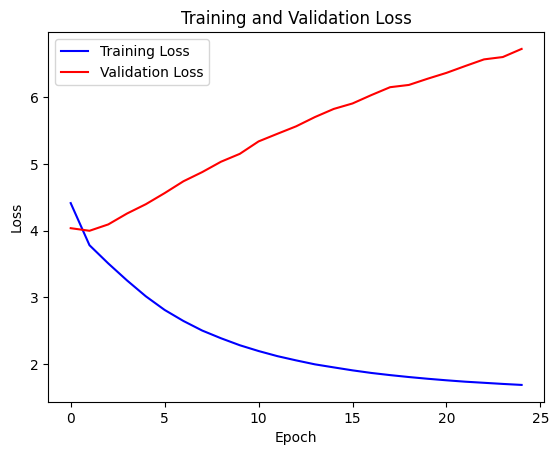

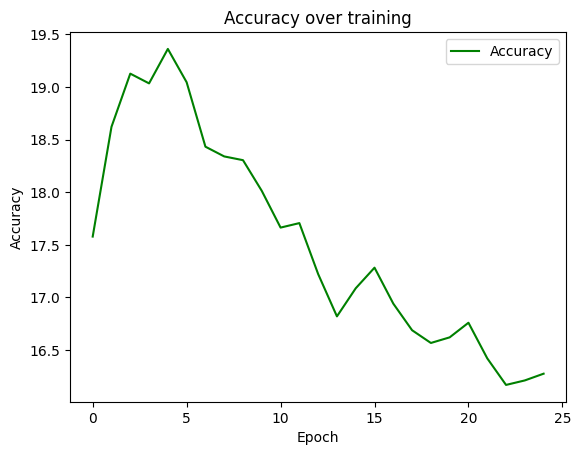

In [32]:
# train_loss = train_loss +tl2
# val_loss = val_loss + vl2
# acc = acc + ac2
# Plot the training and validation losses
import matplotlib.pyplot as plt
plt.plot(range(len(train_loss)), train_loss, label="Training Loss", color="blue")
plt.plot(range(len(train_loss)), val_loss, label="Validation Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()


plt.plot(range(len(train_loss)), acc, label="Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over training")
plt.legend()
plt.show()

In [31]:
correct = test_sentences[0]
testing = correct[:5]      # autocomplete based on

input_test = [word_to_idx[i] for i in testing]
while len(input_test) < 20:
  input_test.append(word_to_idx['EOL'])

print([idx_to_word[i] for i in input_test])
print(input_test)
output = model(torch.tensor(input_test).to(DEVICE))
print(torch.argmax(output, dim=1).tolist())
print([idx_to_word[i] for i in torch.argmax(output, dim=1).tolist()])

['im', 'feeling', 'rather', 'rotten', 'so', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL']
[7718, 928, 8302, 5032, 13441, 5572, 5572, 5572, 5572, 5572, 5572, 5572, 5572, 5572, 5572, 5572, 5572, 5572, 5572, 5572]
[928, 10470, 13361, 8650, 12077, 5572, 5572, 5572, 5572, 5572, 5572, 5572, 5572, 5572, 5572, 5572, 5572, 5572, 5572, 5572]
['feeling', 'a', 'inspired', 'and', 'i', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL']


## Assignment 4B (Learn to pay attention) -- 25% marks

#### Problem Statement

1. Use MNIST Fashion dataset

2. Use the following architecture to force your model to pay attention in the interesting area so that the classification is more correct.

3. Train with your train data. Plot training loss, validation loss for learning rate 0.001 and batch size: 1024/2048 (Which one was best from assignment 3).

4. Run the test on the test split and report confusion matrix and the F1 scores for your test data. Compare your performance with assignment 3

5. Now pick 10 test data (where predictions are right) from 10 classes, pass them through the trained network, produce attention maps for the input images. Show the input images and attention maps with ground truth class name, predicted class name, and probability scores (as shown in page 9 of lecture 5.2).

6. Now randomly pick 30 test data (where prediction were wrong) from 10 classes, pass them through the trained network, produce attention map for the input images. Show the input images and attention maps (for ground truth class and for predicted class ) with ground truth class name, predicted class name, and probability scores (as shown in page 9 of lecture 5.2)

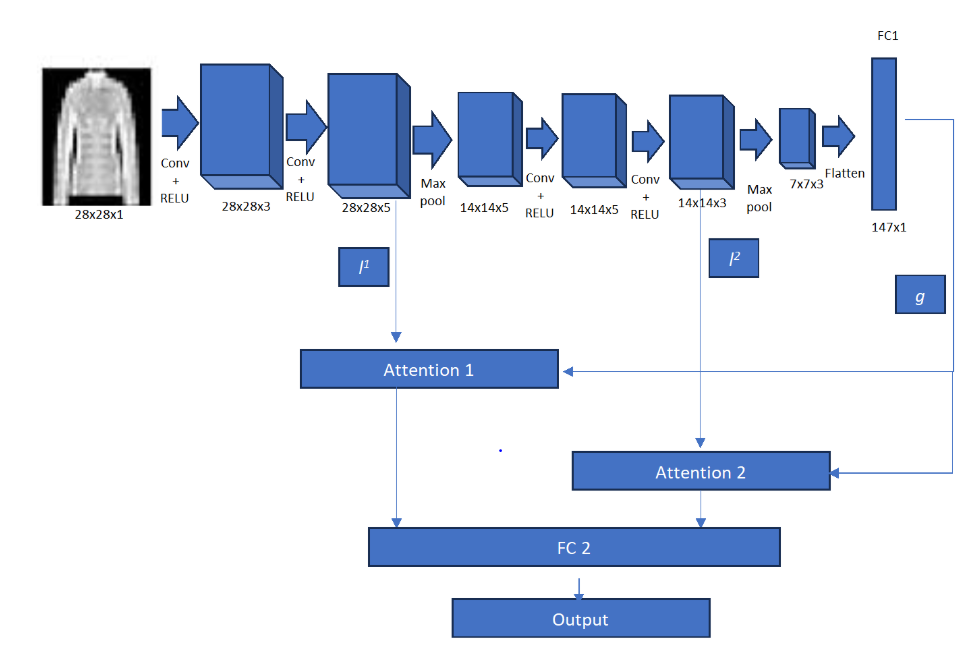

In [ ]:
import torch
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms


# Transformations: Convert to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load the dataset
train_dataset = FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = FashionMNIST(root="./data", train=False, download=True, transform=transform)

100%|██████████| 26.4M/26.4M [00:01<00:00, 17.5MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 332kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.42MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.77MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:

import torch
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader, random_split


# Split train_dataset into 80% train and 20% validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_set, val_set = random_split(train_dataset, [train_size, val_size])

# Display dataset sizes
print(f"Train set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")
print(f"Test set size: {len(test_dataset)}")

# Create DataLoaders
batch_size = 1024  # Use best batch size from Assignment 3
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Train set size: 48000
Validation set size: 12000
Test set size: 10000


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy



class AttentionCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(AttentionCNN, self).__init__()
        # Feature extraction layers
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3, padding=1)  # 28x28x1 -> 28x28x3
        self.conv2 = nn.Conv2d(3, 5, kernel_size=3, padding=1)  # 28x28x3 -> 28x28x5
        self.pool1 = nn.MaxPool2d(2, 2)                        # 28x28x5 -> 14x14x5

        self.conv3 = nn.Conv2d(5, 5, kernel_size=3, padding=1)  # 14x14x5 -> 14x14x5
        self.conv4 = nn.Conv2d(5, 3, kernel_size=3, padding=1)  # 14x14x5 -> 14x14x3
        self.pool2 = nn.MaxPool2d(2, 2)                        # 14x14x3 -> 7x7x3

        self.mapOne1 = nn.Linear(784, 147)
        self.mapOne2 = nn.Linear(784, 147)
        self.mapOne3 = nn.Linear(784, 147)
        self.mapOne4 = nn.Linear(784, 147)
        self.mapOne5 = nn.Linear(784, 147)

        self.mapTwo1 = nn.Linear(196, 147)
        self.mapTwo2 = nn.Linear(196, 147)
        self.mapTwo3 = nn.Linear(196, 147)


        # Dropouts on the fully connected layers
        self.dropout = nn.Dropout(0.5)

        # Fully connected layers
        self.flatten = nn.Flatten()  # 7x7x3 -> 147x1
        self.fc1 = nn.Linear(147, 147)  # New fully connected layer
        self.fc2 = nn.Linear( 1176, num_classes)


    def forward(self, x):
        # Feature extraction
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        l1 = x  # Save l^1 size: #B X 5 X 28 X 28
        l1_copy = x
        l1 = l1.reshape(l1.shape[0], l1.shape[1], -1) # B x 5 x 784

        x = self.pool1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))

        l2 = x  # Save l^2  #B X 3 X 14 X 14
        l2_copy = x
        l2 = l2.reshape(l2.shape[0], l2.shape[1], -1) # B x 3 x 196

        x = self.pool2(x) #B x 3 x 7 x 7
        x = self.flatten(x) # B x 147

        # Fully connected layers
        g = F.relu(self.fc1(x))
        g1 = g.unsqueeze(-1)  # B x 147 x 1
        g2 = g.unsqueeze(-1)  # B x 147 x 1

        # attention calculation

        #here we create 5 diff projections from the 5 channels
        projOne1 = self.mapOne1(l1[:, 0, :]).unsqueeze(1) # B x 1 x 147
        projOne2 = self.mapOne2(l1[:, 1, :]).unsqueeze(1)
        projOne3 = self.mapOne3(l1[:, 2, :]).unsqueeze(1)
        projOne4 = self.mapOne4(l1[:, 3, :]).unsqueeze(1)
        projOne5 = self.mapOne5(l1[:, 4, :]).unsqueeze(1)
        #print(projOne1.shape)

        aOne1 = F.softmax(torch.matmul(projOne1, g1), dim=1) #B X 1 X  1
        aOne2 = F.softmax(torch.matmul(projOne2, g1), dim=1)
        aOne3 = F.softmax(torch.matmul(projOne3, g1), dim=1)
        aOne4 = F.softmax(torch.matmul(projOne4, g1), dim=1)
        aOne5 = F.softmax(torch.matmul(projOne5, g1), dim=1)
        #print(aOne1.shape)

        g_aOne1 = (aOne1*projOne1).squeeze(1) #B x 147
        g_aOne2 = (aOne2*projOne2).squeeze(1)
        g_aOne3 = (aOne3*projOne3).squeeze(1)
        g_aOne4 = (aOne4*projOne4).squeeze(1)
        g_aOne5 = (aOne5*projOne5).squeeze(1)
        #print(g_aOne1.shape)

        g_aOne = torch.cat([g_aOne1, g_aOne2, g_aOne3, g_aOne4, g_aOne5], dim=1)
        #print(g_aOne.shape) #B X 5 X 147

        #attention1 map
              # Calculate weighted channels for attention1
        weighted_channel1 = aOne1 * l1_copy[:, 0, :]  # B x 784
        weighted_channel2 = aOne2 * l1_copy[:, 1, :]
        weighted_channel3 = aOne3 * l1_copy[:, 2, :]
        weighted_channel4 = aOne4 * l1_copy[:, 3, :]
        weighted_channel5 = aOne5 * l1_copy[:, 4, :]

        # Stack all the weighted channels (B x 5 x 28 X 28)
        weighted_channels = torch.stack([weighted_channel1, weighted_channel2, weighted_channel3, weighted_channel4, weighted_channel5], dim=1)
        #print(weighted_channels.shape)

        # Average across the channel axis (B X 28 X 28)
        attention_map1 = weighted_channels.mean(dim=1)
        #print(attention_map1.shape)


        #attention 2

        projTwo1 = self.mapTwo1(l2[:, 0, :]).unsqueeze(1) #B X 1 X 147
        projTwo2 = self.mapTwo2(l2[:, 1, :]).unsqueeze(1) #B X 1 X 147
        projTwo3 = self.mapTwo3(l2[:, 2, :]).unsqueeze(1) #B X 1 X 147

        aTwo1 = F.softmax(torch.matmul(projTwo1, g1), dim=1)
        aTwo2 = F.softmax(torch.matmul(projTwo2, g1), dim=1)
        aTwo3 = F.softmax(torch.matmul(projTwo3, g1), dim=1)
        #print(aTwo1.shape) #B X 1 X 1

        g_aTwo1 = (aTwo1*projTwo1).squeeze(1)
        g_aTwo2 = (aTwo2*projTwo2).squeeze(1)
        g_aTwo3 = (aTwo3*projTwo3).squeeze(1)
        g_aTwo = torch.cat([g_aTwo1, g_aTwo2, g_aTwo3], dim=1)
        #print(g_aTwo.shape) #B X 3 X 147

        x = torch.cat([g_aOne, g_aTwo], dim=1)
        #print(x.shape) # B X 8 X 147
        x.flatten(1)

        #To create HEATMAP2
        # Calculate softmax weighted channels for attention2
        weighted_channel2_1 = aTwo1 * l2_copy[:, 0, :]  # B x 196
        weighted_channel2_2 = aTwo2 * l2_copy[:, 1, :]
        weighted_channel2_3 = aTwo3 * l2_copy[:, 2, :]

        # Stack all the weighted channels (B x 3 x 196)
        weighted_channels2 = torch.stack([weighted_channel2_1, weighted_channel2_2, weighted_channel2_3], dim=1)

        # Average across the channel axis (B x 196), creating a single map for each sample
        attention_map2 = weighted_channels2.mean(dim=1)  # B x 196

        # Reshape into 14x14 for visualization (B x 14 x 14)
        attention_map2 = attention_map2.view(-1, 14, 14)  # B x 14 x 14


        # Final classification
        x = self.fc2(x)  # Output logits
        return x, attention_map1, attention_map2


In [ ]:
import torch.optim as optim

# Initialize model, loss, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AttentionCNN(num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        outputs, l1, l2 = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, l1, l2 = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_loss / len(test_loader))
    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")


Epoch 1, Train Loss: 1.1902892399341503, Validation Loss: 0.5911523699760437
Epoch 2, Train Loss: 0.4853131415996146, Validation Loss: 0.46877615749835966
Epoch 3, Train Loss: 0.41366376458330356, Validation Loss: 0.4320208042860031
Epoch 4, Train Loss: 0.38330319206765356, Validation Loss: 0.41098790168762206
Epoch 5, Train Loss: 0.3630695805904713, Validation Loss: 0.39720056653022767
Epoch 6, Train Loss: 0.346295638921413, Validation Loss: 0.39003010988235476
Epoch 7, Train Loss: 0.33521017685849613, Validation Loss: 0.37993837893009186
Epoch 8, Train Loss: 0.32052850786675796, Validation Loss: 0.37379845678806306
Epoch 9, Train Loss: 0.30718192965426344, Validation Loss: 0.3558963030576706
Epoch 10, Train Loss: 0.2999480480843402, Validation Loss: 0.3598722815513611


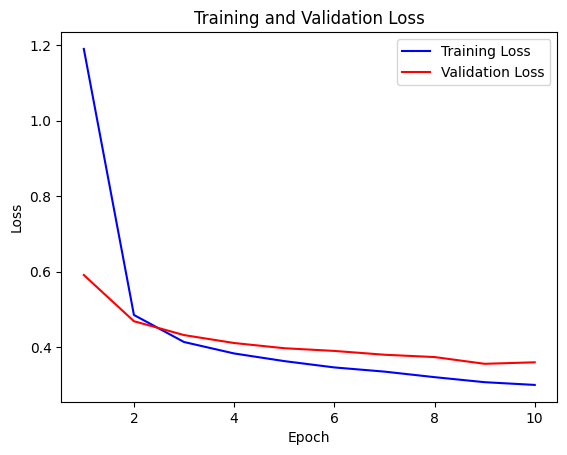

In [ ]:
import matplotlib.pyplot as plt
# Plot the training and validation losses
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss", color="blue")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

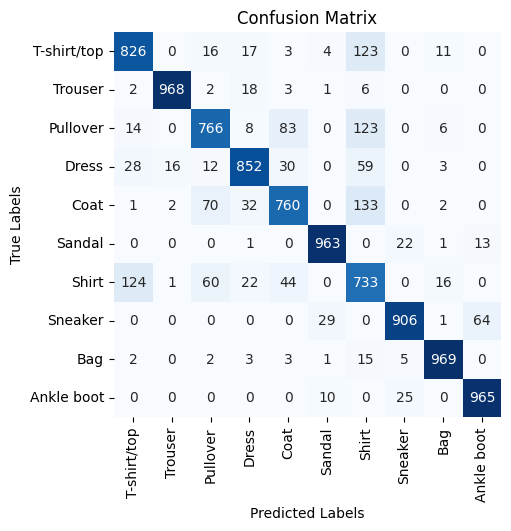

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1000
           1       0.98      0.97      0.97      1000
           2       0.83      0.77      0.79      1000
           3       0.89      0.85      0.87      1000
           4       0.82      0.76      0.79      1000
           5       0.96      0.96      0.96      1000
           6       0.61      0.73      0.67      1000
           7       0.95      0.91      0.93      1000
           8       0.96      0.97      0.96      1000
           9       0.93      0.96      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate on test data
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs, l1, l2 = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Seaborn heatmap for confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Classification report
report = classification_report(all_labels, all_preds)
print(f"Classification Report:\n{report}")

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def create_heatmaps(input_image, attention1, attention2):
    batch_size = input_image.size(0)

    for b in range(batch_size):
        # Get single input image
        img = input_image[b].squeeze().cpu().numpy()  # Shape: [28, 28]

        # Normalize Attention 1
        heatmap1 = attention1.cpu().numpy()  # Shape: [28, 28]
        heatmap1 -= heatmap1.min()
        if heatmap1.max() > 0:
            heatmap1 /= heatmap1.max()  # Normalize to [0, 1]

        # Ensure attention2[b] has the correct shape
        #print(f"Shape of attention2[{b}]: {attention2.shape}")  # Debugging the shape

        attention2_b = attention2.unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, 28, 28]

        # Verify the shape after unsqueeze
        #print(f"Shape of attention2_b after unsqueeze: {attention2_b.shape}")  # Debugging the shape

        # Upsample and Normalize Attention 2

        heatmap2 = F.interpolate(attention2_b, size=(28, 28), mode="bilinear", align_corners=True).squeeze().cpu().numpy()  # Upsample to [28, 28]
        heatmap2 -= heatmap2.min()
        if heatmap2.max() > 0:
            heatmap2 /= heatmap2.max()  # Normalize to [0, 1]

        # Plot original image and heatmaps
        fig, axes = plt.subplots(1, 3, figsize=(9, 3))

        # Original Image
        axes[0].imshow(img, cmap='gray')
        axes[0].set_title("Original Image")

        # Heatmap 1 (Attention 1)
        axes[1].imshow(img, cmap='gray')
        axes[1].imshow(heatmap1, cmap='jet', alpha=0.5)
        axes[1].set_title("Attention 1 Heatmap")

        # Heatmap 2 (Attention 2, upsampled)
        axes[2].imshow(img, cmap='gray')
        axes[2].imshow(heatmap2, cmap='jet', alpha=0.5)
        axes[2].set_title("Attention 2 Heatmap (Upsampled)")

        for ax in axes:
            ax.axis('off')

        plt.tight_layout()
        plt.show()


Visualizing Incorrect Predictions:


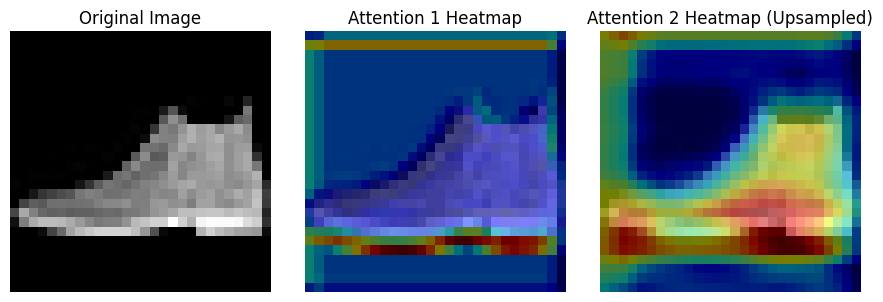

Ground Truth: Ankle boot, Predicted: Ankle boot, Probability: 0.9589214324951172


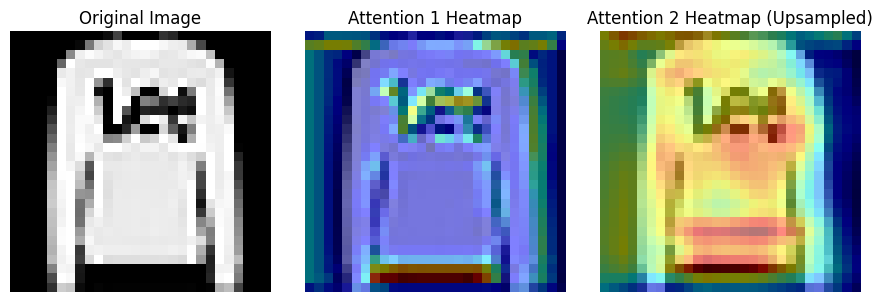

Ground Truth: Pullover, Predicted: Pullover, Probability: 0.9877929091453552


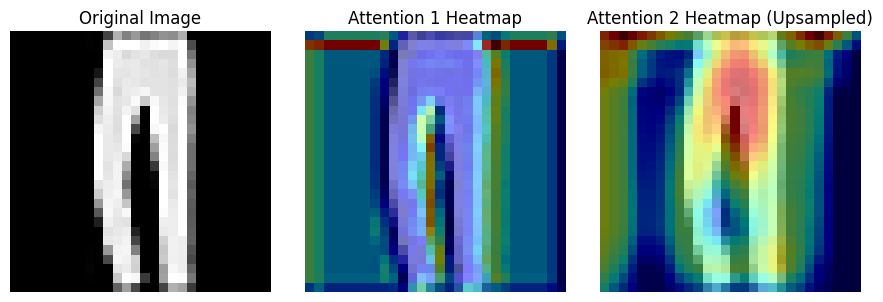

Ground Truth: Trouser, Predicted: Trouser, Probability: 0.9999785423278809


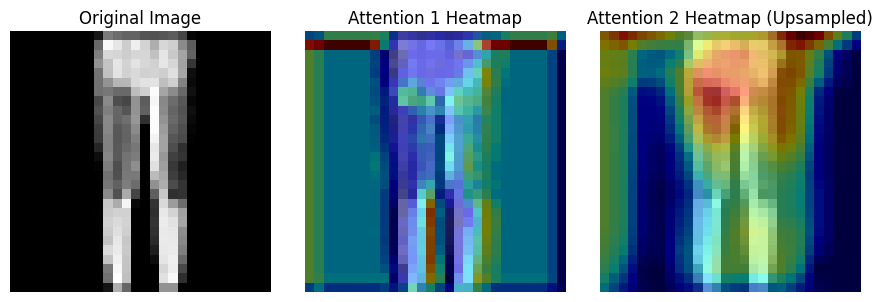

Ground Truth: Trouser, Predicted: Trouser, Probability: 0.9999768733978271


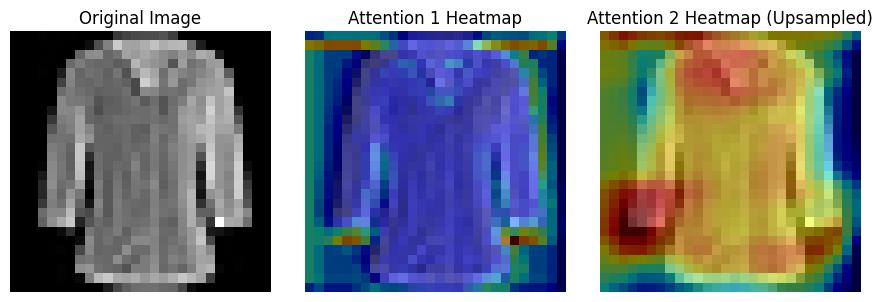

Ground Truth: Shirt, Predicted: Shirt, Probability: 0.9137125015258789


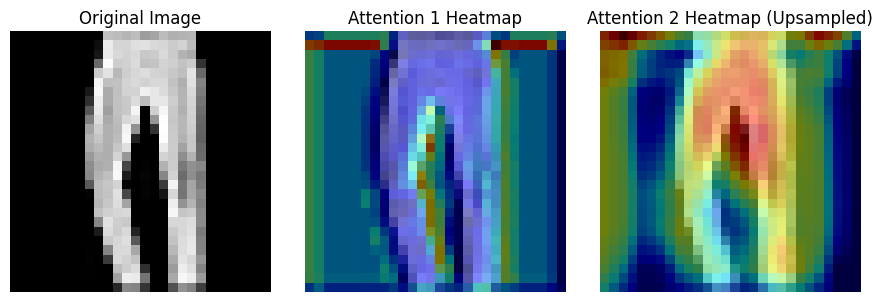

Ground Truth: Trouser, Predicted: Trouser, Probability: 0.9997913241386414


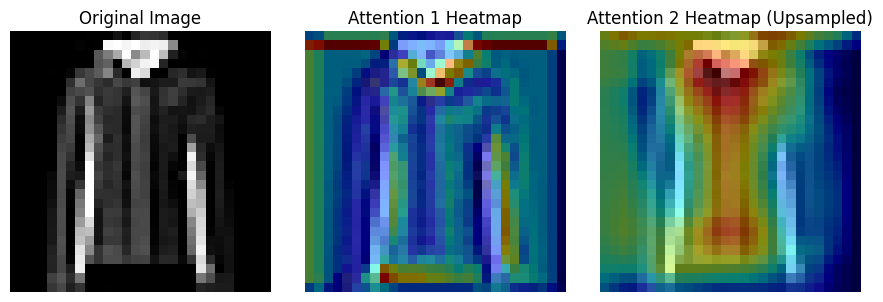

Ground Truth: Coat, Predicted: Coat, Probability: 0.9110408425331116


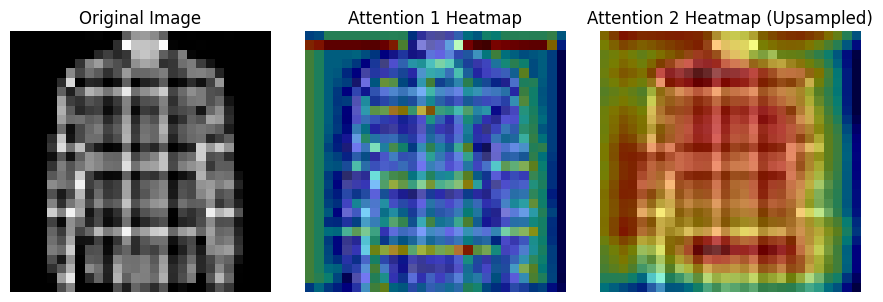

Ground Truth: Shirt, Predicted: Shirt, Probability: 0.9945557117462158


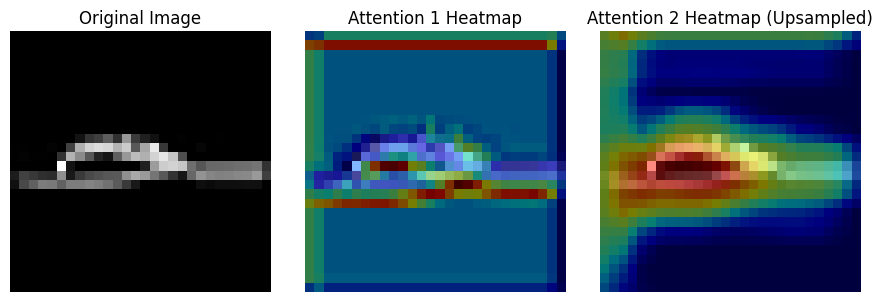

Ground Truth: Sandal, Predicted: Sandal, Probability: 0.9711336493492126


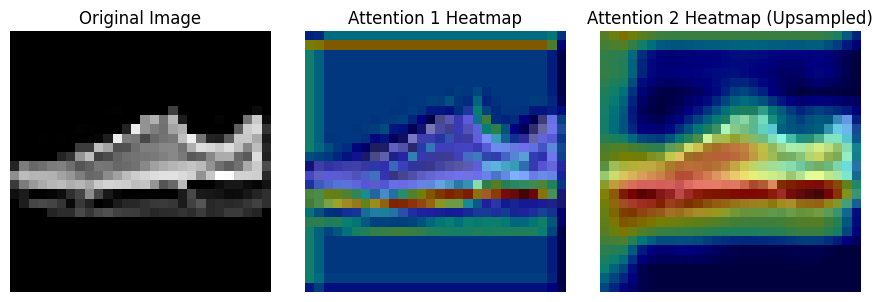

Ground Truth: Sneaker, Predicted: Sneaker, Probability: 0.997930645942688


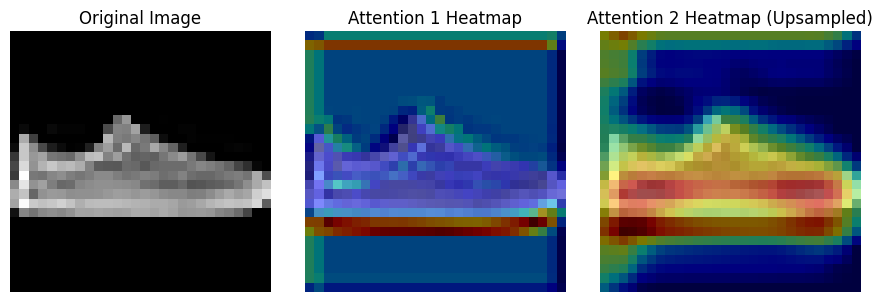

Ground Truth: Sneaker, Predicted: Sandal, Probability: 0.3977419435977936


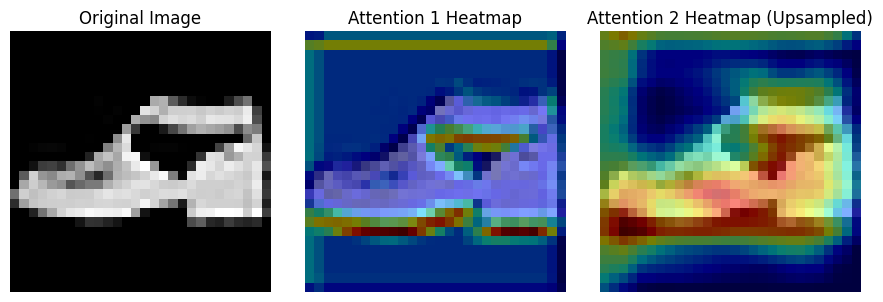

Ground Truth: Ankle boot, Predicted: Sandal, Probability: 0.9969593286514282


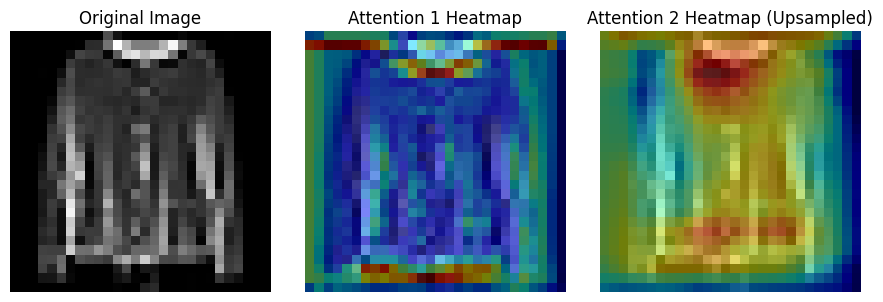

Ground Truth: Coat, Predicted: Shirt, Probability: 0.5677876472473145


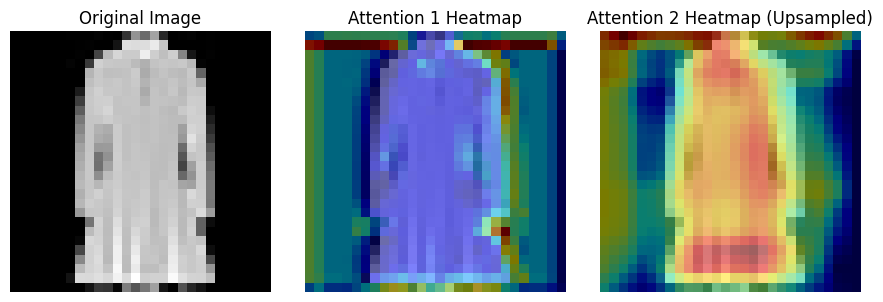

Ground Truth: Dress, Predicted: Shirt, Probability: 0.5034260153770447


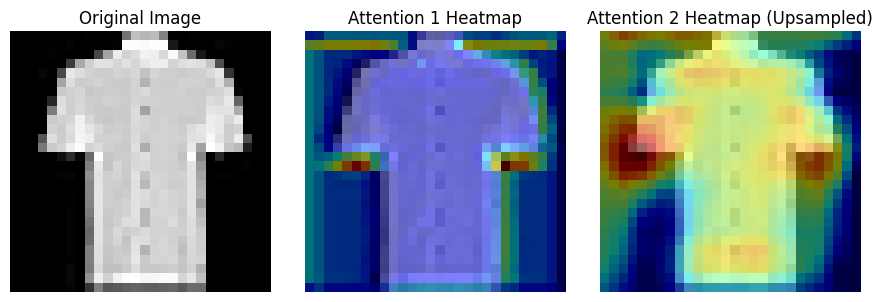

Ground Truth: Shirt, Predicted: T-shirt/top, Probability: 0.6162392497062683


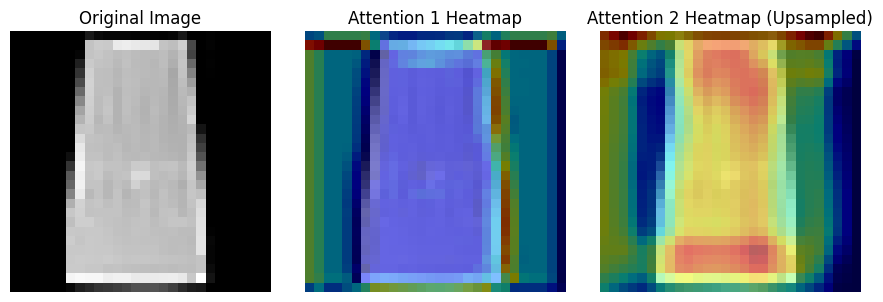

Ground Truth: Dress, Predicted: T-shirt/top, Probability: 0.2888442873954773


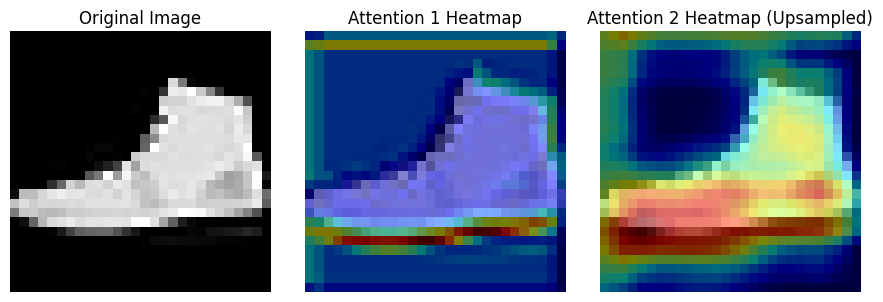

Ground Truth: Sneaker, Predicted: Ankle boot, Probability: 0.5526862144470215


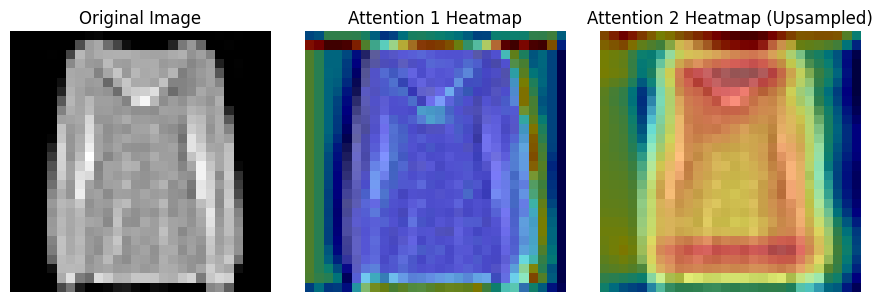

Ground Truth: Pullover, Predicted: Shirt, Probability: 0.8864129781723022


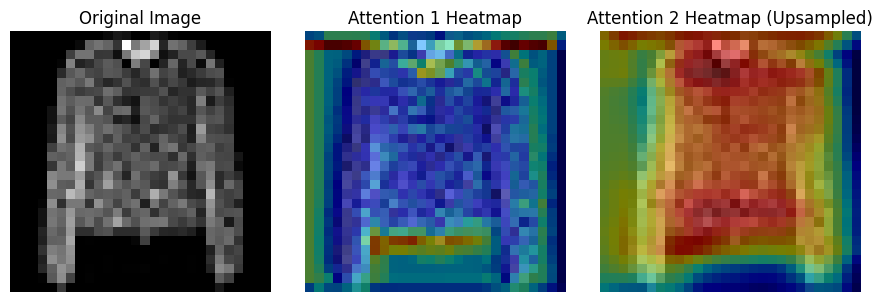

Ground Truth: Coat, Predicted: Shirt, Probability: 0.49336761236190796


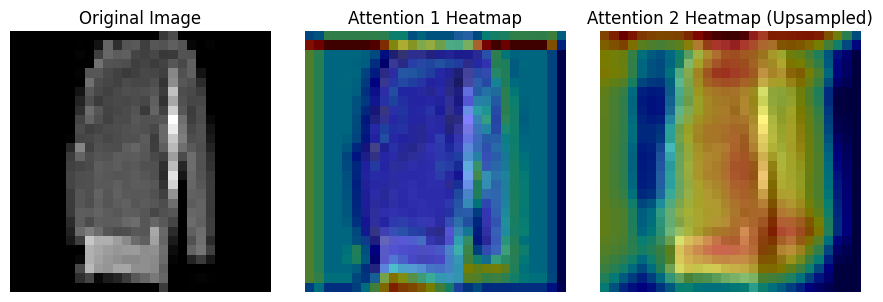

Ground Truth: Pullover, Predicted: Dress, Probability: 0.3911212086677551


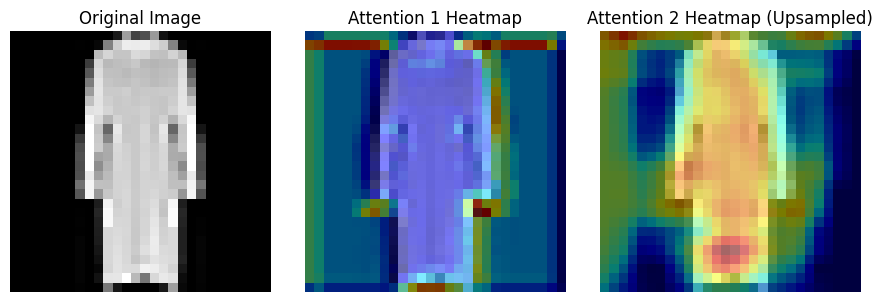

Ground Truth: Dress, Predicted: Coat, Probability: 0.5562063455581665


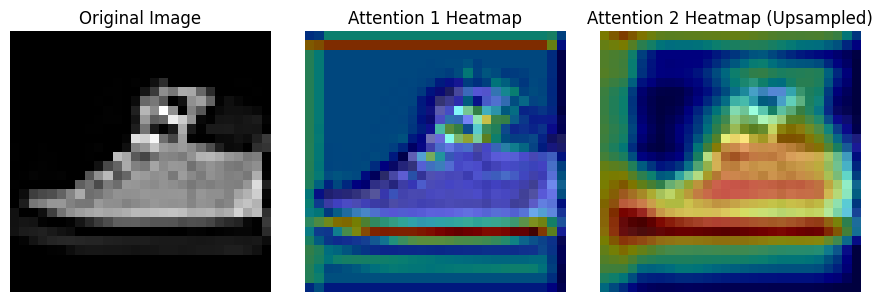

Ground Truth: Ankle boot, Predicted: Sneaker, Probability: 0.939667820930481


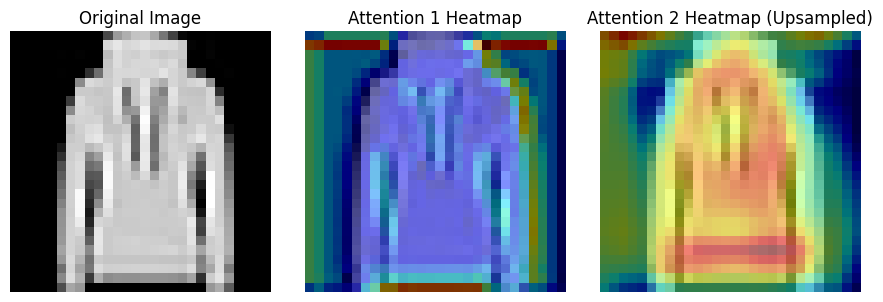

Ground Truth: Pullover, Predicted: Coat, Probability: 0.5535716414451599


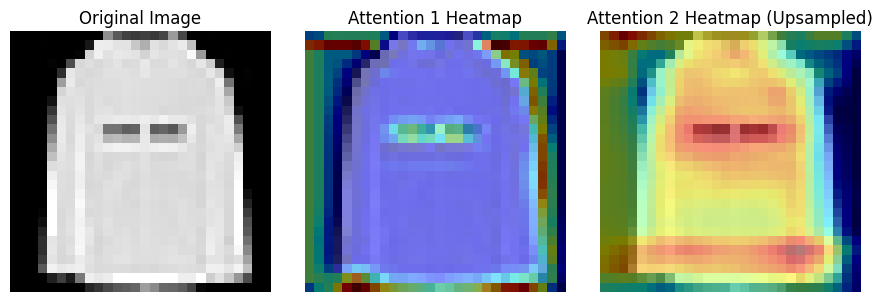

Ground Truth: Coat, Predicted: Pullover, Probability: 0.35010072588920593


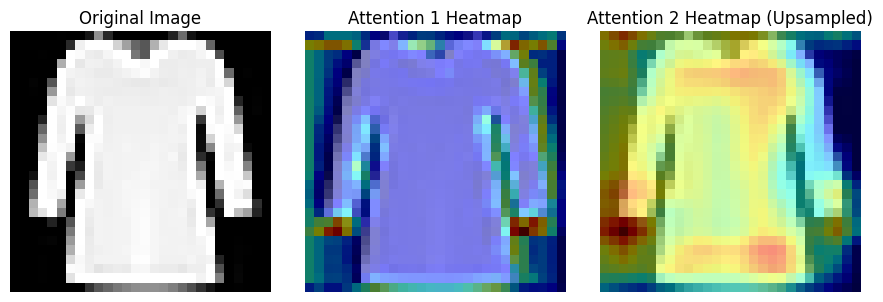

Ground Truth: T-shirt/top, Predicted: Shirt, Probability: 0.4363352358341217


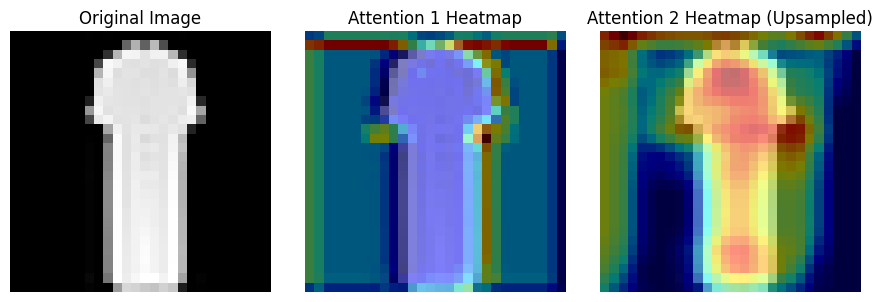

Ground Truth: Shirt, Predicted: Dress, Probability: 0.9102040529251099


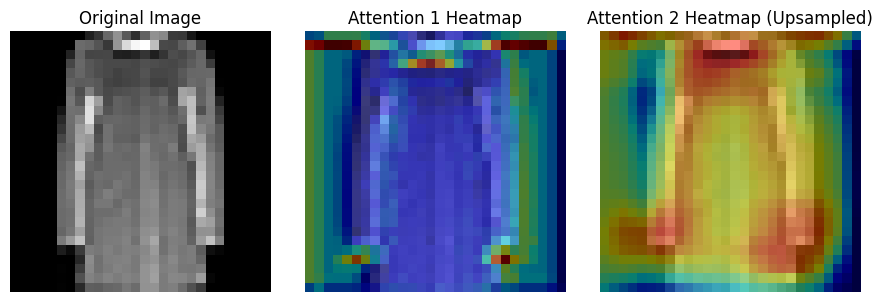

Ground Truth: Coat, Predicted: Dress, Probability: 0.40801337361335754


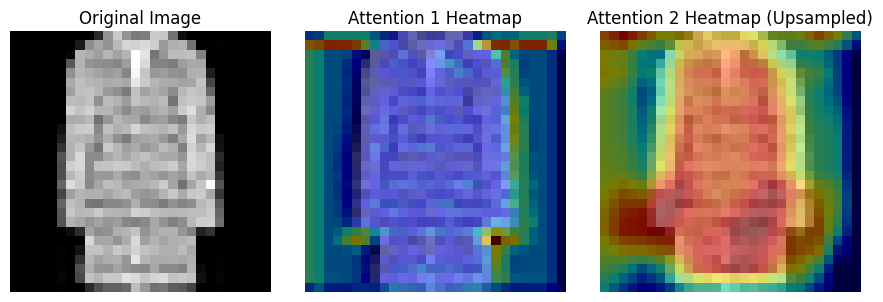

Ground Truth: Coat, Predicted: Dress, Probability: 0.7893232703208923


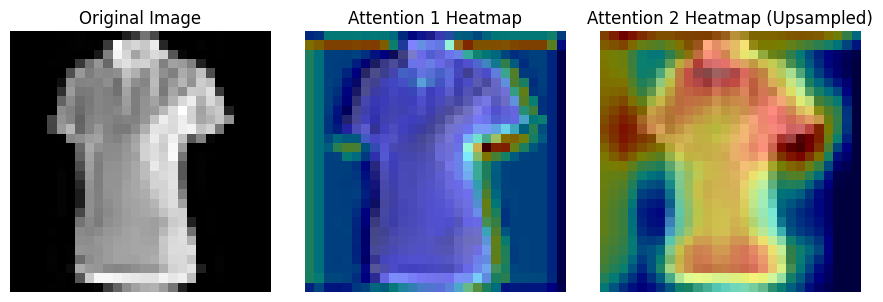

Ground Truth: T-shirt/top, Predicted: Shirt, Probability: 0.5415934920310974


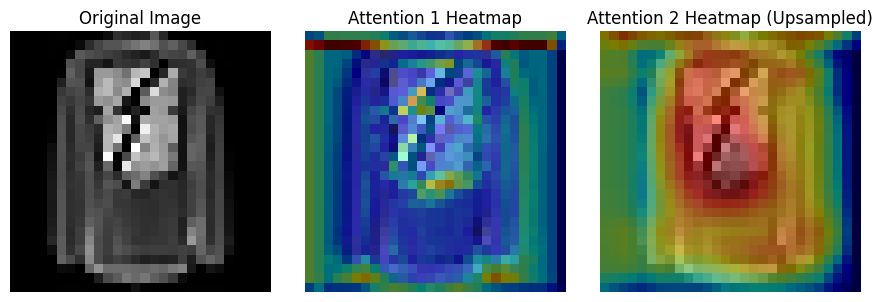

Ground Truth: Pullover, Predicted: Shirt, Probability: 0.4573412537574768


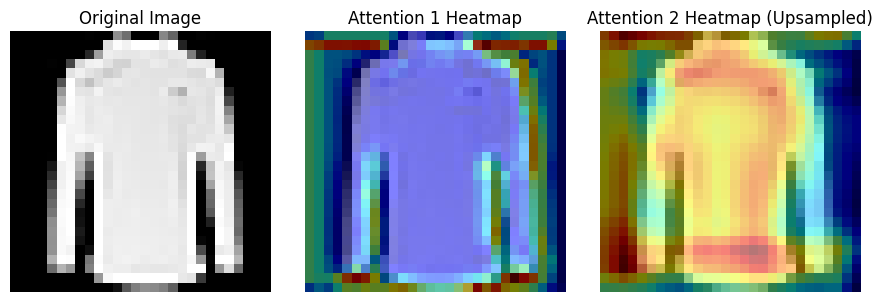

Ground Truth: Pullover, Predicted: Shirt, Probability: 0.6701323986053467


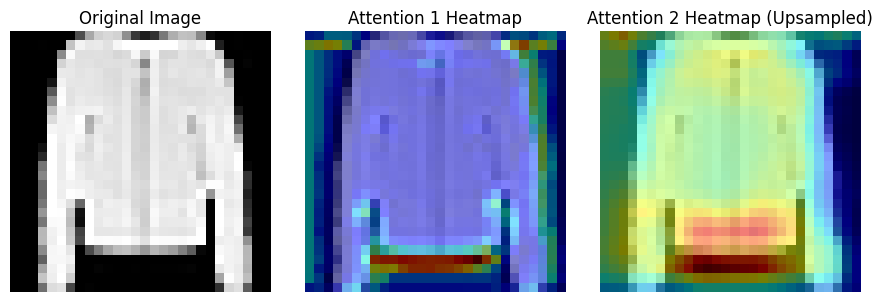

Ground Truth: Coat, Predicted: Pullover, Probability: 0.8097949624061584


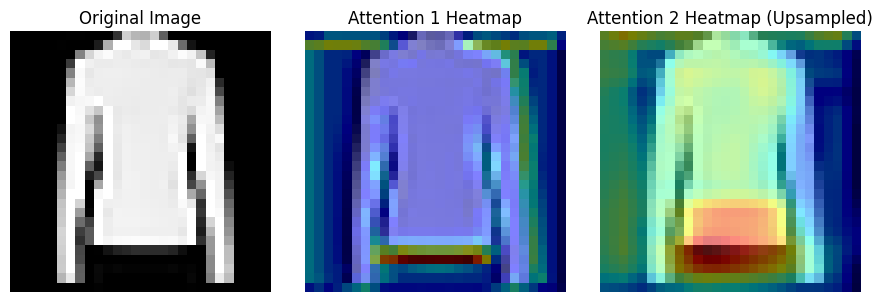

Ground Truth: Shirt, Predicted: Pullover, Probability: 0.5626934766769409


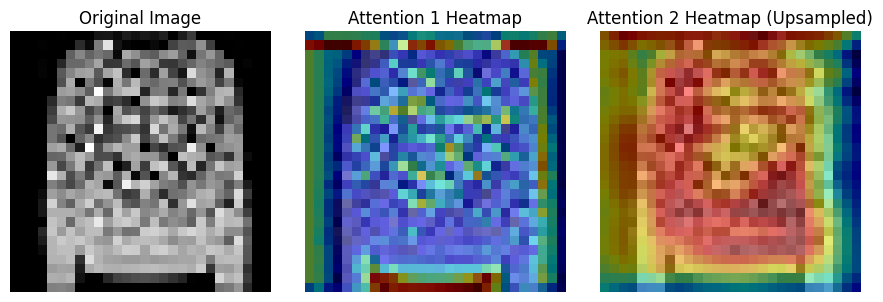

Ground Truth: Pullover, Predicted: Shirt, Probability: 0.9238882660865784


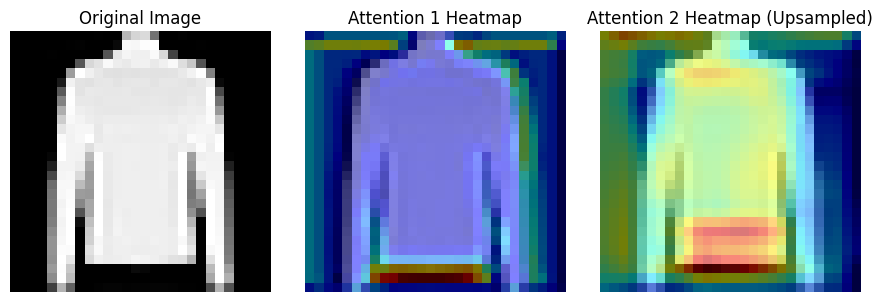

Ground Truth: Pullover, Predicted: Shirt, Probability: 0.5306736826896667


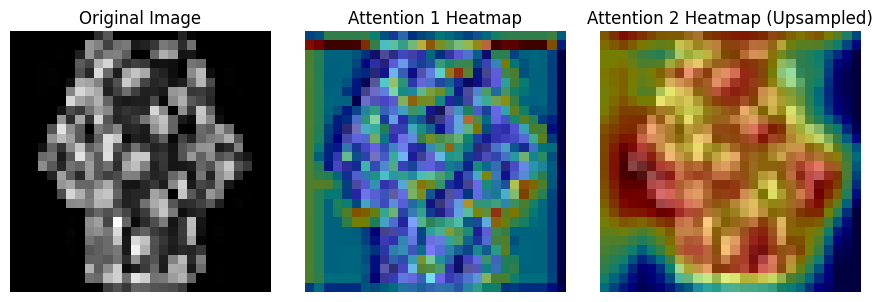

Ground Truth: Dress, Predicted: Shirt, Probability: 0.6066483855247498


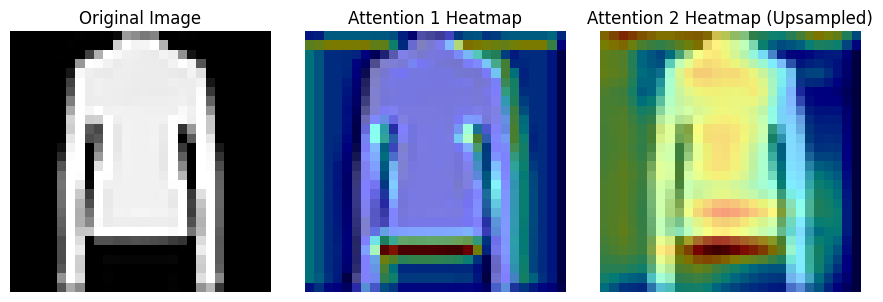

Ground Truth: Pullover, Predicted: Shirt, Probability: 0.42233309149742126


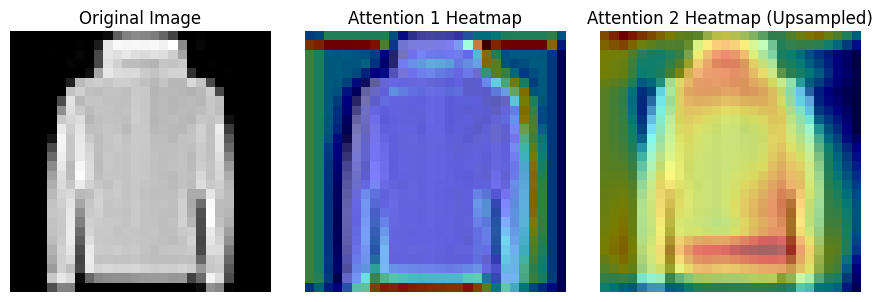

Ground Truth: Coat, Predicted: Pullover, Probability: 0.6430700421333313


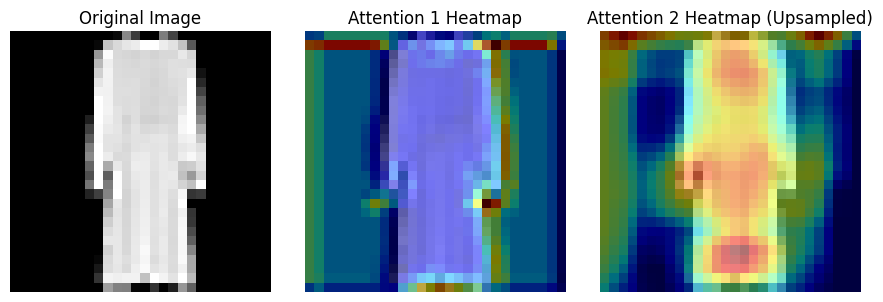

Ground Truth: Dress, Predicted: Coat, Probability: 0.5179943442344666


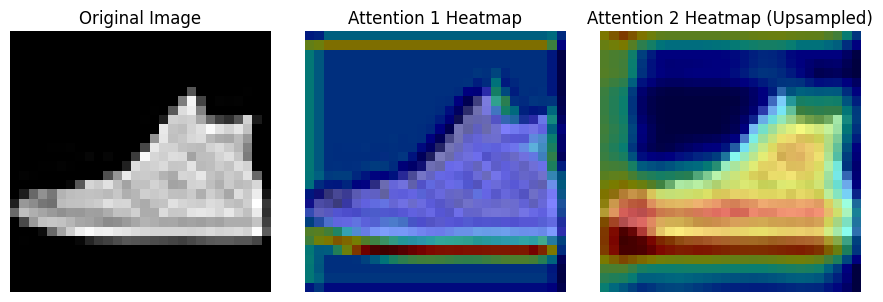

Ground Truth: Sneaker, Predicted: Ankle boot, Probability: 0.5082570910453796


In [ ]:


# Visualize correctly classified samples
def visualize_correct_predictions(model, test_loader, num_samples=30, label_dict=label_dict):
    model.eval()
    count = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, attention1, attention2 = model(inputs)
            prob = F.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, dim=1)

            for i in range(inputs.size(0)):
                if preds[i] == labels[i] and count < num_samples:
                    # Incorrect prediction
                    #print(attention1.shape, attention2.shape)
                    create_heatmaps(inputs[i], attention1[i], attention2[i])
                    print(f"Ground Truth: {label_dict[labels[i].item()]}, Predicted: {label_dict[preds[i].item()]}, Probability: {prob[i][preds[i]].item()}")
                    count += 1
                if count >= num_samples:
                    return

# Visualize incorrectly classified samples
def visualize_incorrect_predictions(model, test_loader, num_samples=30, label_dict=label_dict):
    model.eval()
    count = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, attention1, attention2 = model(inputs)
            prob = F.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, dim=1)

            for i in range(inputs.size(0)):
                if preds[i] != labels[i] and count < num_samples:
                    # Incorrect prediction
                    #print(attention1.shape, attention2.shape)
                    create_heatmaps(inputs[i], attention1[i], attention2[i])
                    print(f"Ground Truth: {label_dict[labels[i].item()]}, Predicted: {label_dict[preds[i].item()]}, Probability: {prob[i][preds[i]].item()}")
                    count += 1
                if count >= num_samples:
                    return

print("Visualizing Incorrect Predictions:")
visualize_correct_predictions(model, test_loader, num_samples=10)
visualize_incorrect_predictions(model, test_loader, num_samples=30)
